In [1]:
import os
import datetime
import time
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization,MaxPooling2D,Dense,concatenate
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate,Conv2DTranspose
from tensorflow.keras.layers import Input,UpSampling3D,Dense, Dropout,BatchNormalization, Activation
from tensorflow.keras.layers import GlobalAveragePooling2D, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint,LearningRateScheduler
from tensorflow.keras.metrics import Recall, Precision,MeanIoU,AUC
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model


/Users/user/miniforge3/envs/Apple/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
BATCH_SIZE = 16
IMG_SIZE = (256, 256)

# train_dir = './dataset/TBNTBN/train/'
test_dir = './dataset/TBNTBN/test/'

In [3]:
from scripts.create_dataset import create_dataset

In [4]:
from sklearn.preprocessing import LabelBinarizer
train = LabelBinarizer()

In [5]:
train_data, train_y =create_dataset(test_dir,IMG_SIZE)
target_val = train.fit_transform(train_y)


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(train_data, ), 
                                                    target_val, 
                                                    test_size=0.15,
                                                    random_state=42)


In [7]:
def build_model(input_shape):
    inputs = Input(shape=input_shape, name="input_image")
    mobilenetv2 = tf.keras.applications.MobileNetV2(
        input_tensor = inputs, 
        weights="imagenet", include_top=False, alpha=0.35)
    
    x = mobilenetv2.get_layer('out_relu').output
    x = GlobalAveragePooling2D(name='gap')(x)
    output = Dense(3,activation='softmax')(x)
    return tf.keras.Model(inputs,output)

In [8]:
model = build_model(input_shape=(256,256,3))
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
                         loss='binary_crossentropy',
                         metrics=['accuracy'])

model.load_weights('output/class_weights.06-0.05.hdf5')


Metal device set to: Apple M1


2022-10-03 10:10:13.508774: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-03 10:10:13.508858: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
model.evaluate(X_test,y_test)

2022-10-03 10:10:14.316441: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-10-03 10:10:14.316589: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-03 10:10:14.625743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 100ms/step - loss: 0.4800 - accuracy: 0.8667


[0.4800480902194977, 0.8666666746139526]

In [10]:
from scripts.create_dataset import get_img_array
from scripts.display_heatmap import save_and_display_gradcam
from scripts.model_explanation import make_cam_heatmap, make_gradcam_heatmap, make_grad_cam_pp_heatmap

In [11]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from IPython.display import Image, display

1 [1.6380182e-02 9.8361969e-01 4.4627580e-08]
2 [9.9865037e-01 1.3487353e-03 9.7903353e-07]
3 [5.449576e-05 9.999455e-01 7.426651e-10]
4 [4.0668881e-05 9.9995923e-01 6.8061759e-08]
5 [4.6847854e-04 9.9953032e-01 1.1805488e-06]
6 [2.7195336e-03 9.9724448e-01 3.6024230e-05]
7 [8.6215105e-06 6.2209391e-04 9.9936932e-01]
8 [0.0303892  0.02012582 0.9494849 ]
9 [9.9872535e-01 1.1622462e-03 1.1235548e-04]
10 [9.999229e-01 1.088619e-05 6.623496e-05]


/var/folders/6b/0t1qb1d92f72c46kvp35pwfc0000gn/T/ipykernel_8366/2680257855.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(100,60))


<Figure size 1152x1152 with 0 Axes>

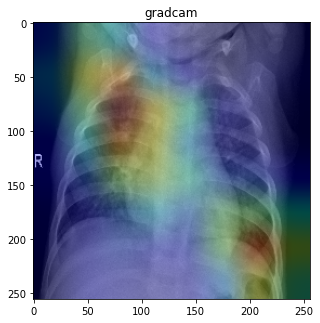

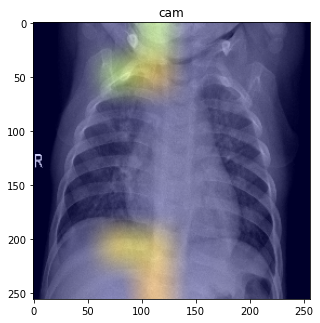

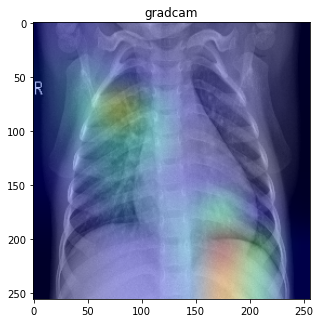

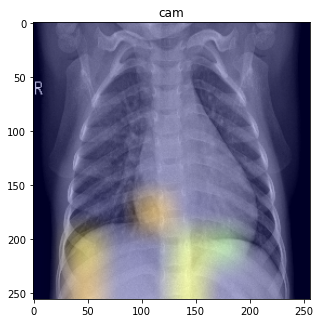

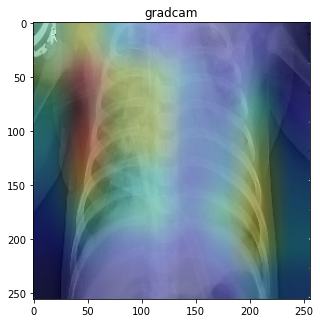

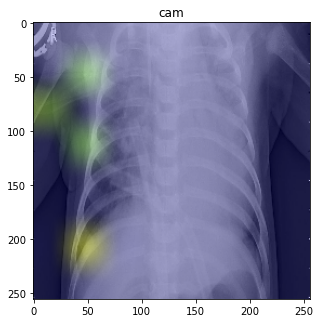

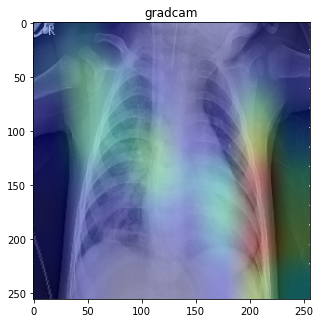

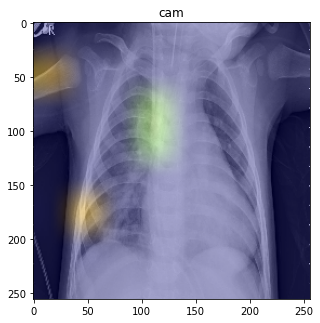

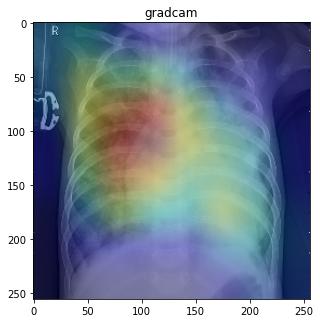

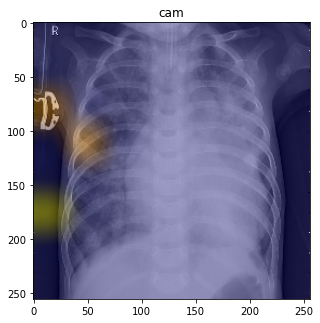

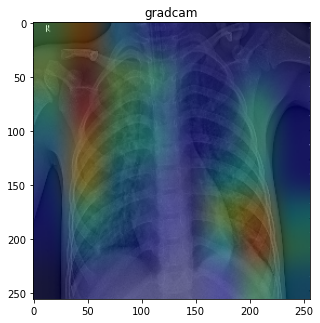

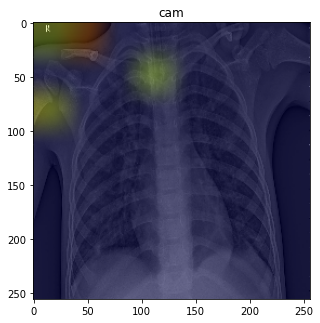

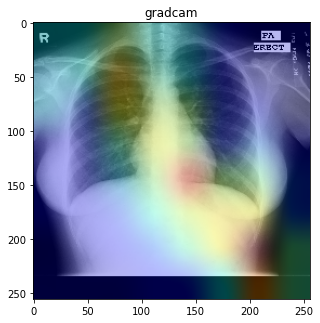

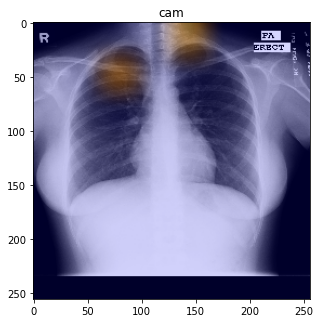

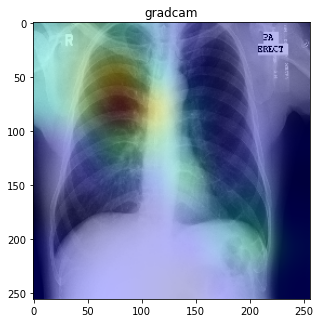

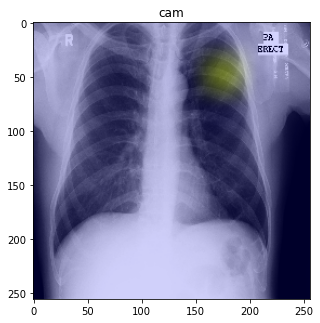

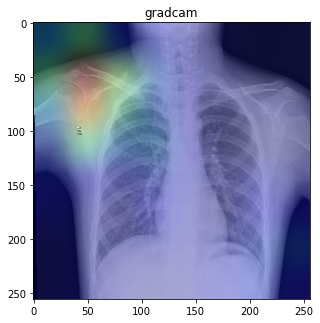

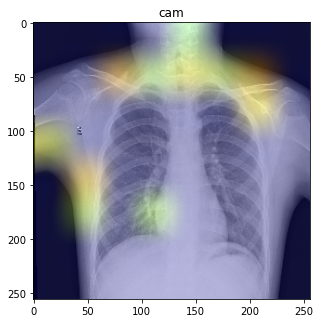

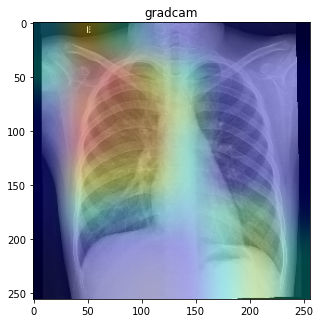

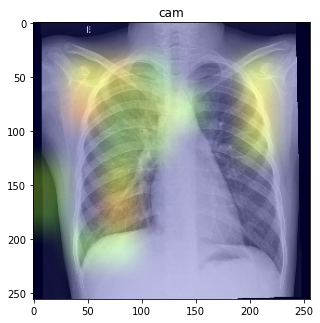

In [70]:
plt.figure(figsize=(16, 16))

for count in range(1,11):#(len(filename)):
#     im = cv2.imread(filename[count])
#     im = cv2.resize(im, (256,256), interpolation = cv2.INTER_AREA)
#     img = tf.keras.preprocessing.image.load_img(
#         filename[count],
#         color_mode='rgb', 
#         target_size=(256, 256))
#     img = tf.keras.preprocessing.image.img_to_array(img)
    img = X_test[count+10]
    im = img
    img = np.reshape(img,(1,256,256,3))
    print(count,max(model.predict(img)))
   
    heatmap_cam = make_cam_heatmap(img, model, 'out_relu')
    heatmap_cam = np.where(heatmap_cam > 0.5, heatmap_cam, 0)
    heatmap_cam = np.where(heatmap_cam < 0.8, heatmap_cam, 0)
    heatmap_gradcam = make_grad_cam_pp_heatmap(img, model, 'out_relu')
    save_and_display_gradcam(im, heatmap_gradcam,2*count-1,title='gradcam')
    save_and_display_gradcam(im, heatmap_cam,2*count,title='cam')
    

In [38]:
!git add .
!git commit -m 'explanaction and localization'

[unet 9bd6ff7] explanaction and localization
 13 files changed, 1580 insertions(+), 497 deletions(-)
 create mode 100644 .DS_Store
 create mode 100644 classification_model.sav
 create mode 100644 models/classification_model.pkl
 create mode 100644 models/classification_model.sav


In [39]:
!git status

On branch unet
nothing to commit, working tree clean


In [15]:
!git push origin unet

Enumerating objects: 18, done.
Counting objects: 100% (18/18), done.
Delta compression using up to 8 threads
Compressing objects: 100% (10/10), done.
Writing objects: 100% (10/10), 1.40 MiB | 1.55 MiB/s, done.
Total 10 (delta 5), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (5/5), completed with 5 local objects.
To https://github.com/degagawolde/DeepLearningBasedTBDiagnosis.git
   79283b8..1ebc77c  unet -> unet
